# Leveraging Social Media to Identify Major Historic Flood Events, Notebook 2/3: 

## Twitter Data EDA & Further Investigation

#### Contents
- [EDA](#EDA)
- [Evaluation of flood events by tweet frequency](#Evaluation-of-flood-events-by-tweet-frequency)
- [CountVectorizer & Most Frequent Words](#CountVectorizer-&-Most-Frequent-Words)

#### Library Import

In [2]:
# Load libraries and functions
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Turn off warnings to reduce angry red-space in notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### EDA

#### Select city and date range of interest (same as used for corresponding Twitter scrape)

In [4]:
city = 'Manila'
start_date = dt.date(2014, 1, 1)
end_date = dt.date(2018, 1, 1)

In [5]:
# Read .csv created with above parameters
df = pd.read_csv(f'../data/tweetscrape_{city}_{start_date}_to_{end_date}.csv')

In [6]:
# Create df with only columns of interest
tweets = df[['username', 'tweet_id', 'timestamp', 'timestamp_epochs', 'retweets', 'text']]

In [7]:
# How many tweets are we dealing with?
tweets.shape

(702, 6)

* Houston: 33,036
* Manila: 702

In [8]:
# What data-type is our timestamp column?
tweets['timestamp'].dtypes

dtype('O')

In [9]:
# Are there any NaNs to deal with?
tweets.isna().sum()

username            0
tweet_id            0
timestamp           0
timestamp_epochs    0
retweets            0
text                0
dtype: int64

#### Timestamp adjustment

##### Remove seconds and convert to date-time

In [10]:
# loop through rows to remove seconds from each timestamp

date_list = []

for tweet in tweets['timestamp']:
    tweet = tweet.replace(' ', '')[:-8] # Remove seconds from the timestamp
    date_list.append(tweet)
    
tweets['clean_date'] = date_list # Save as new column in tweets df

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [11]:
# Change Y-M-D object to datetime format
tweets['clean_date'] = pd.to_datetime(tweets['clean_date'], format='%Y-%m-%d')

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Convert original timestamp to datetime

In [12]:
# Convert original timestamp to datetime to preserve seconds
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# Check all dtypes to make sure everything is as it should be
tweets.dtypes

username                    object
tweet_id                     int64
timestamp           datetime64[ns]
timestamp_epochs             int64
retweets                     int64
text                        object
clean_date          datetime64[ns]
dtype: object

In [14]:
# Check out numeric variables
tweets.describe()

,tweet_id,timestamp_epochs,retweets
count,7.020000e+02,7.020000e+02,702.000000
mean,6.183217e+17,1.436254e+09,0.988604
std,1.508104e+17,3.595600e+07,7.882329
min,4.204171e+17,1.389070e+09,0.000000
25%,5.127474e+17,1.411083e+09,0.000000
50%,5.504848e+17,1.420081e+09,0.000000
75%,7.250259e+17,1.461695e+09,0.000000
max,9.446527e+17,1.514058e+09,187.000000


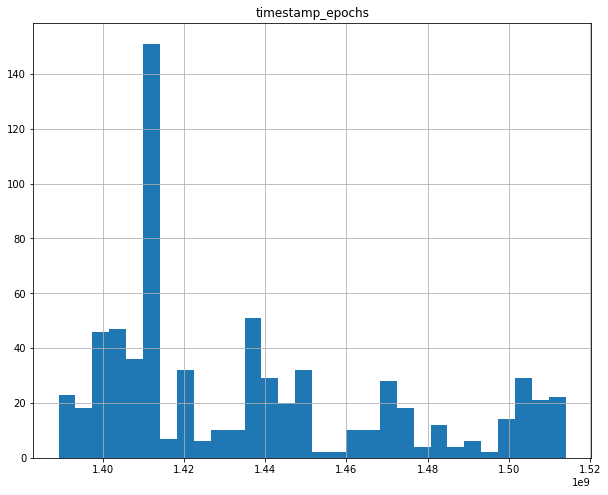

In [15]:
# Check out distribution of tweets using timestamp_epochs
# Which is the numerical representation of time
tweets.hist(column = 'timestamp_epochs', bins = 30, figsize = (10, 8));

**Note:** 
* Houston: 3 major "events" are evident, this will be explored further using timestamps for clarification.
* Manila: 1 _major_ "event" is evident, many more smaller events as well, but the data is also noisier.

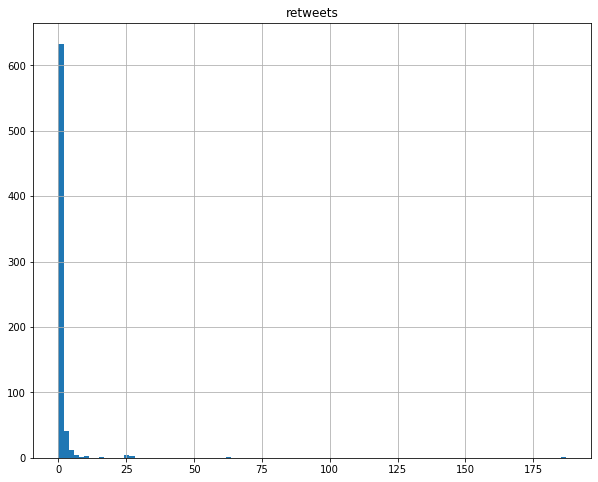

In [16]:
# What does the distribution of retweets look like?
tweets.hist(column = 'retweets', bins = 100, figsize = (10, 8));

**Note:** 
* Houston: This plot does not appear to tell us anything constructive, which was to be expected given the stats in `.describe()`--a mean number of retweets=4.6 with a standard deviation of 84.3 was definitely not normal/horribly skewed.
* Manila: Similar to Houston, but with a mean number of retweets = 0.99, and a standard deviation of 7.9, produced similar results.

#### Identify and drop duplicate tweets

In [17]:
# Identify duplicate tweet content (identical shared newsitems, users with multiple twitter accounts, etc)
tweets[tweets.duplicated(['text'])]

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date
11,aaronrecuenco,840133530529161218,2017-03-10 09:33:37,1489138417,0,Two kids die of electrocution in floodwaters o...,2017-03-10
12,LittleMaviLearn,834248603971391488,2017-02-22 03:49:01,1487735341,0,Hundreds rescued from California floodwaters i...,2017-02-22
13,Naskoivanov72,830571439396888576,2017-02-12 00:17:17,1486858637,0,Filipino boys play basketball in floodwaters f...,2017-02-12
14,foreca,812637994729566208,2016-12-24 12:36:10,1482582970,1,Typhoon Nock-ten crosses through the northern ...,2016-12-24
15,johnnyhosg,812623093336150017,2016-12-24 11:36:57,1482579417,0,https://plus.google.com/115160545770949042069/...,2016-12-24
...,...,...,...,...,...,...,...
506,lyndajumilla,518001492754591745,2014-10-03 11:35:54,1412336154,4,"Heavy rain, no let-up, for 20 minutes now in m...",2014-10-03
557,christian_aid,513009690864021504,2014-09-19 17:00:16,1411146016,3,Metro #Manila & surrounding areas are under wa...,2014-09-19
697,WB_AsiaPacific,475872431199223808,2014-06-09 05:30:03,1402291803,1,#Philippines: Metro Manila #Flood Risk Managem...,2014-06-09
698,WB_AsiaPacific,474611742832877568,2014-06-05 18:00:32,1401991232,0,#Philippines: Metro Manila #Flood Risk Managem...,2014-06-05


In [18]:
# Drop duplicate tweets
tweets = tweets.drop_duplicates(['text'])

In [19]:
# How many tweets remaining?
tweets.shape

(522, 7)

**Tweets remaining for further analysis:** <br>

* Houston: 28,139 <br>
* Manila: 522

In [20]:
# How many unique timestamps once duplicates are dropped?
tweets['timestamp'].nunique()

518

**Note:** As all timestamps are not unique, our data cannot be treated as an ideal timeseries/our tweets cannot be indexed by timestamp.
* Houston: 26,738
* Manila: 522

In [21]:
# How many posts with >50 retweets?
tweets[tweets['retweets'] > 50].shape

(2, 7)

* Houston: 296 (<1%)
* Manila: 2 (<1%)

### Evaluation of flood events by tweet frequency

In [22]:
# Thus our clean_date becomes the index for our data...
daily_tweets = tweets.groupby(tweets['clean_date'])[['text']].count()

#### Plot daily tweet count and weekly-averaged tweet count

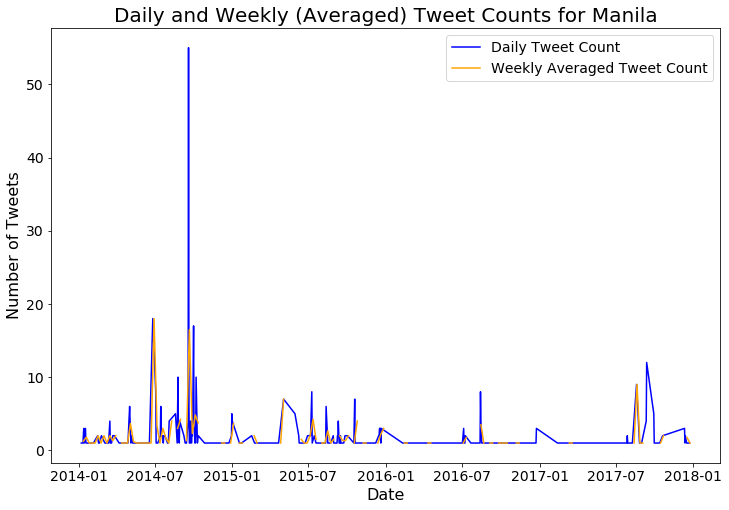

In [23]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Weekly Averaged Tweet Count'], fontsize = 14);
ax.set_title(f'Daily and Weekly (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/dailyct_and_weeklyavg_tweets_{city}.png')

**Notes:** 
* Houston: Significant upticks in tweet activity in May 2015, May 2016, and August 2017 correspond to major flooding events in Houston. Smaller but still clear upticks in Oct/Nov 2015, June 2016, and Feb 2017 correspond to recorded and newsworthy floods as well. The major upticks' visibility in the weekly average as well is evidence that these events were not extremely brief and/or minimally impactful. A small uptick in June 2017 corresponds to the "storm that wasn't", when Tropical Storm Cindy was forecast to drop much more precipitation than it actually did.
* Manila: Biggest uptick in Aug 2014, other verifiable upticks noted in Aug 2016 and Sept 2017, corresponding to flood events that showed up in the news. It is necessary to note that significant flood events are very common in the Philippines, and often do not make the news, so not all upticks are verifiable.

#### Plot daily tweet count and annually-averaged tweet count

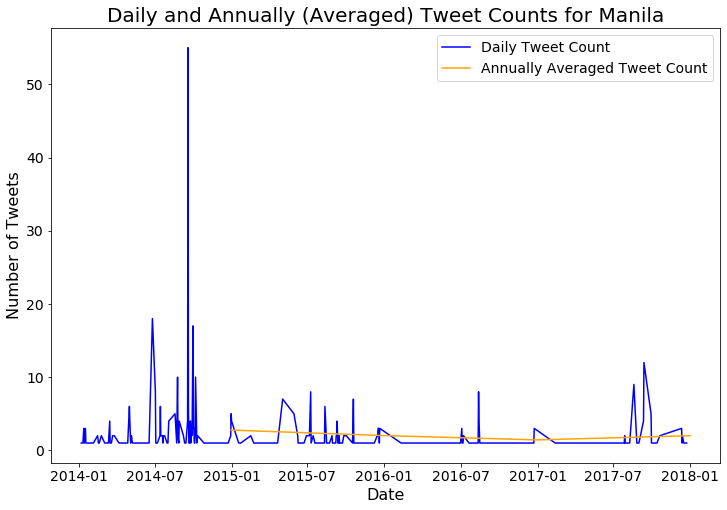

In [24]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('A').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Annually Averaged Tweet Count'], fontsize = 14);
ax.set_title(f'Daily and Annually (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/dailyct_and_annavg_tweets_{city}.png')

**Notes:** Annually averaged tweets are useful because they provide a baseline with which to compare any increase in twitter activity. From what we have determined, any visible increase from this baseline seems to corresponded to an impactful flood event.
* Houston: 2014-2016 have fairly low baselines, but 2017's is much higher/relatively skewed because of the extended and heavy impact of the August flood event (Hurricane Harvey) on the twitter-sphere.
* Manila: Baseline low across the board--but overall flood-related tweet frequency in Manila is much lower than in Houston, too, which has an effect.

#### Mean annual and above-average daily tweet counts

In [25]:
# Overall average can be skewed by an anomalous year
daily_tweets['text'].mean()

2.2695652173913046

In [26]:
# Get annual averaged numbers of tweets
mean_ann_tweets = daily_tweets[['text']].resample('A').mean()

In [27]:
# Set index of mean_ann_tweets to year instead of year-month-day default based on daily_tweets
mean_ann_tweets.index = mean_ann_tweets.index.year

In [28]:
mean_ann_tweets

,text
clean_date,
2014,2.771429
2015,2.016949
2016,1.428571
2017,2.000000


**<center>Mean Annual Tweets<center>**

| | Houston | Manila |
|--|--|--|
|2014| 4.28 | 2.77 |
|2015| 18.85 | 2.02 |
|2016| 18.19 | 1.43 |
|2017 | 92.58 | 2.00 |

In [29]:
daily_tweets.index

DatetimeIndex(['2014-01-07', '2014-01-09', '2014-01-11', '2014-01-12',
               '2014-01-13', '2014-01-14', '2014-01-17', '2014-01-18',
               '2014-01-19', '2014-01-21',
               ...
               '2017-10-13', '2017-10-20', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-16', '2017-12-19', '2017-12-20',
               '2017-12-22', '2017-12-23'],
              dtype='datetime64[ns]', name='clean_date', length=230, freq=None)

In [30]:
# Identify all days with tweet counts greater than their respective annual average
# With assistance from Noah Christiansen
bool_list = []
for i in range(len(daily_tweets)):
    # Find days with tweet counts greater than their annual average
    bool_list.append(daily_tweets['text'][i] >= mean_ann_tweets.loc[daily_tweets.index[i].year,'text']) 
daily_tweets['above_avg'] = bool_list

In [31]:
# Create new dataframe just for days with above average tweet counts
above_avg_tweets = daily_tweets.loc[daily_tweets['above_avg'] == True].drop(columns = 'above_avg')

In [32]:
(above_avg_tweets.resample('W').sum())['text']

clean_date
2014-01-19    6
2014-01-26    0
2014-02-02    0
2014-02-09    0
2014-02-16    0
             ..
2017-11-19    0
2017-11-26    0
2017-12-03    0
2017-12-10    0
2017-12-17    5
Freq: W-SUN, Name: text, Length: 205, dtype: int64

In [33]:
# Do our values make sense?
above_avg_tweets.head()

,text
clean_date,
2014-01-13,3
2014-01-17,3
2014-03-16,4
2014-05-02,6
2014-05-03,4


In [34]:
# Yes, they do, given our known baselines!
above_avg_tweets.tail()

,text
clean_date,
2017-09-12,12
2017-09-29,5
2017-10-20,2
2017-12-11,3
2017-12-13,2


#### Plot weekly and monthly means

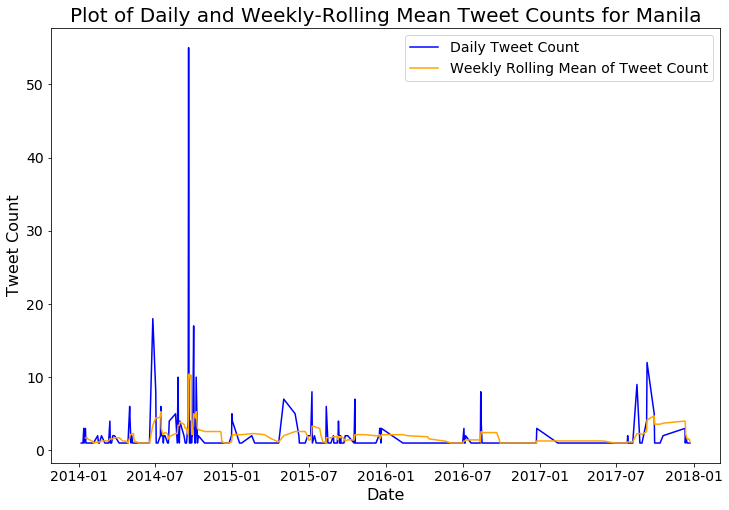

In [35]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], label = 'Daily Tweet Count', color = 'blue');
ax.plot(daily_tweets['text'].rolling(7).mean(), label = 'Weekly Rolling Mean of Tweet Count', color = 'orange');
ax.set_title(f'Plot of Daily and Weekly-Rolling Mean Tweet Counts for {city}', fontsize = 20);
ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Tweet Count', fontsize = 16);
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize = 14)
plt.savefig(f'../figs/daily_weeklyrollingmean_{city}.png')


**Notes:**
* Houston: Major events visible in weekly mean as well daily count, less significant events are dampened.
* Manila: Major events still somewhat visible in weekly means, but heavily dampened/smaller scale of data makes it easier to lose information with averaging.

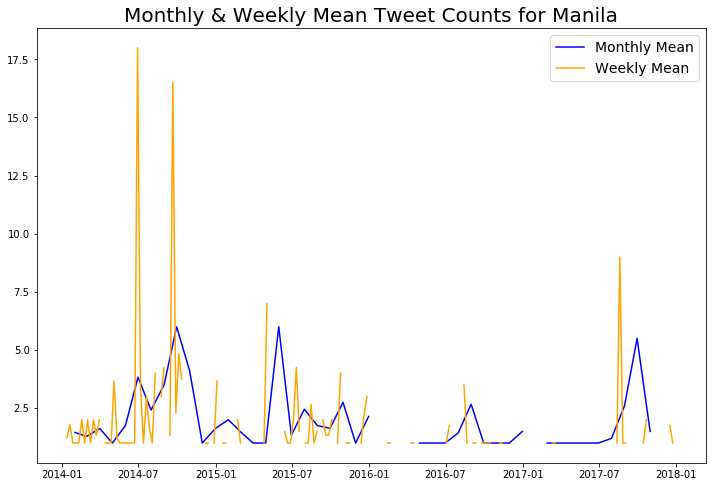

In [36]:
plt.figure(figsize = (12, 8))
plt.plot(daily_tweets['text'].resample('M').mean(), color = 'blue');
plt.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
plt.title(f'Monthly & Weekly Mean Tweet Counts for {city}', fontsize = 20)
plt.legend(['Monthly Mean', 'Weekly Mean'], fontsize = 14);

**Notes:**
* Houston: Major events still visible in both means, more minor events get dampened by longer time-averages.
* Manila: Monthly average ignores a lot of minor events.

#### Plot daily above-average tweet counts

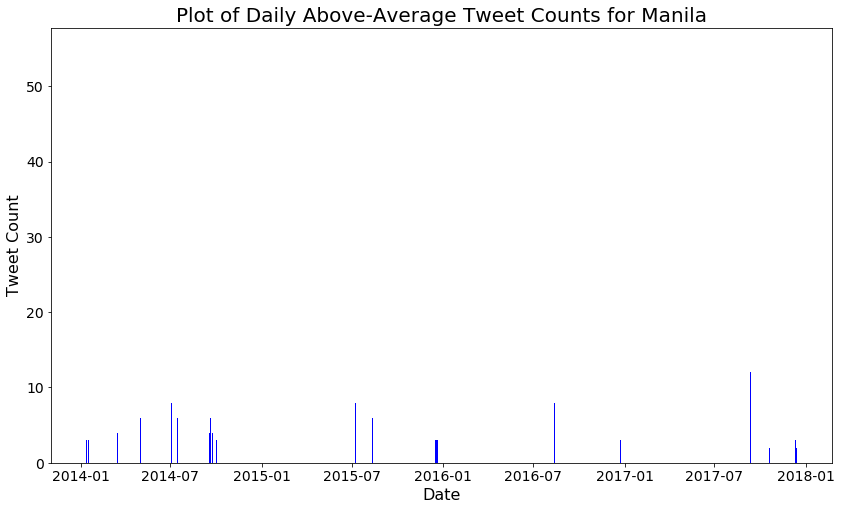

In [37]:
plt.figure(figsize = (14, 8))
plt.bar(above_avg_tweets['text'].index, above_avg_tweets['text'], color = 'blue');
plt.title(f'Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Tweet Count', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/daily_abvavg_{city}.png')

**Notes:** 
* Houston: Major events still visible, smaller events in 2017 have been dampened out by the overwhelming impact of Hurricane Harvey. 
* Manila: Many individual events become clear. While it might be useful to look at tweets on smaller timescale here to determine how extended the impact is, tweet volume is so low in Manila that there isn't really enough data to produce a useful analysis.

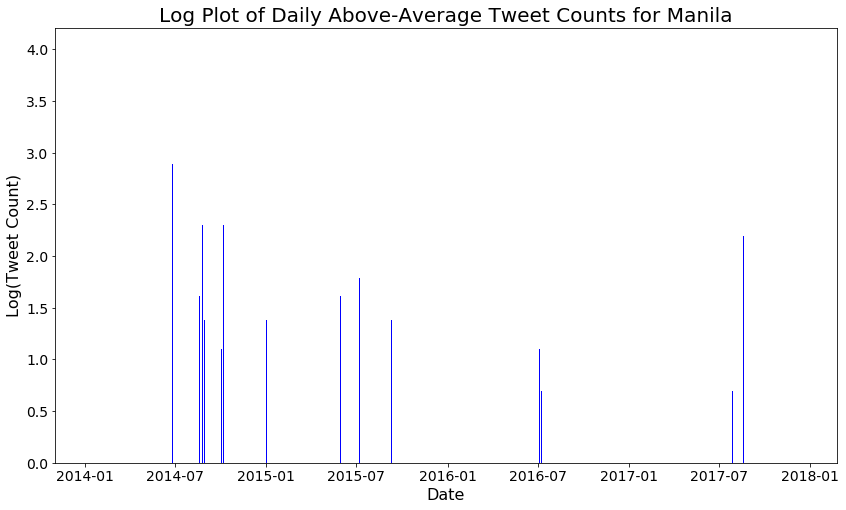

In [38]:
# Log plots are helpful for increasing the visibility of small-but-significant values
plt.figure(figsize = (14, 8));
plt.bar(above_avg_tweets['text'].index, np.log(above_avg_tweets['text']), color = 'blue');
plt.title(f'Log Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Log(Tweet Count)', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/log_daily_abvavg_{city}.png')

**Notes:**
* Houston: Smaller-impact events are more obvious in the log-plot. And all visible events in the plot seem to correspond to actual recorded flooding events.
* Manila: Events become more clear, but even so, not all floods are in the public/easily accessible record.

### CountVectorizer & Most Frequent Words

In [39]:
# Additional stopwords selected by their presence in the most frequently occurring words in our data
stopWords = ['com', 'http', 'twitter', 'https', 'pic', 'www', 'ly', 
             'yahoo', 'yhoo', 'youtu', 'youtube', 'fb', 'instagram', 
             'tt', 'html', 'goo', 'gl', 'google'] + list(ENGLISH_STOP_WORDS) 

In [40]:
# Initiate instance of CountVectorizer for tweet data
cvec_tw = CountVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

# Pull out 'text' column
X_tw = tweets['text']

# Fit the vectorizer to our corpus
cvec_tw.fit(X_tw)

# Transform the training corpus
X_tw = cvec_tw.transform(X_tw)

# Convert result into a dataframe
X_tw_df = pd.DataFrame(X_tw.toarray(),
                          columns=cvec_tw.get_feature_names())
X_tw_df.head()

,000,07,13,131,15,19,1ouosbc,1pic,20,2013,...,wong,work,world,wow,year,years,yesterday,yolanda,youscoop,zhandercayabyab
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X_tw_df.shape

(522, 500)

In [42]:
# Save 20 most frequently appearing words to a df, in descending order
tw_bardat = X_tw_df.sum().sort_values(ascending = False)[0:20].to_frame()

In [43]:
tw_bardat.index

Index(['manila', 'flood', 'philippines', 'bit', 'metro', 'flooding', 'floods',
       'rain', 'floodwaters', 'disaster', 'traffic', 'news', 'heavy',
       'typhoon', 'storm', 'floodwater', 'flooded', 'baha', 'areas', 'ph'],
      dtype='object')

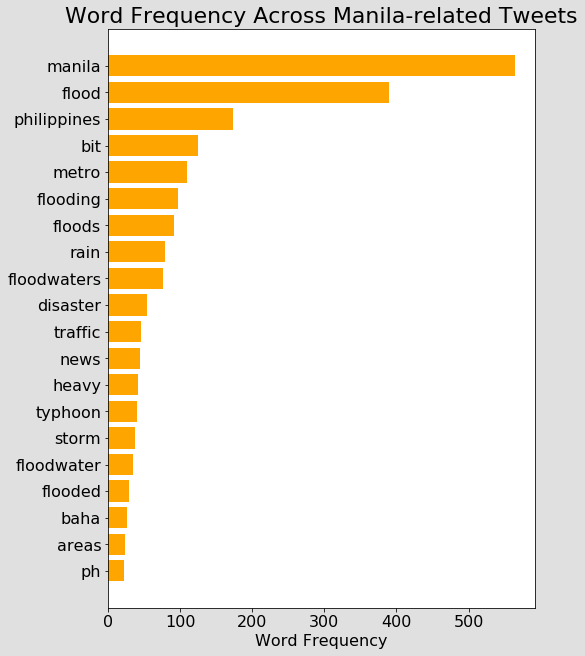

In [44]:
# Plot top 20 most frequently occurring words in {city} tweets
fig, ax = plt.subplots(figsize=(8, 9), sharex = True, constrained_layout = True, # Share x axes to keep ranges the same
                              facecolor = '#E0E0E0')  # Set figure facecolor to match slide theme
ax.barh(tw_bardat.index, tw_bardat[0], color = 'orange');
ax.invert_yaxis(); # Flip plot vertically so values descending from top
ax.set_title(f'Word Frequency Across {city}-related Tweets', fontsize = 22);
ax.set_xlabel('Word Frequency', fontsize = 16);
ax.set_yticklabels(tw_bardat.index, fontsize = 14)
ax.tick_params(labelsize = 16)
         

**Notes:**
* Houston: Most frequently occurring words tend to come from keywords used in the twitter scrape. Something interesting to note is that Harvey-related words appear twice in the top 20 words. While Hurricane Harvey was a massive storm that wreaked havoc in Houston, its impact on twitter seems outsized--it wasn't the ~2 orders of magnitude more significant than the twitter activity suggests. What this shows is that twitter activity should _not_ be used as a direct metric of the physical/financial/etc impact of a flood on a given city. On the other hand, where there is above average twitter activity about flooding...a flood is very likely to be found.
* Manila: Similar to Houston, though note the presence of "typhoon"--referring to a more regional type of storm than would be seen in Houston. Also, "baha" means "flood" or "lots of water" in Tagalog--even though the scrape pulled English-language tweets only, transliteration still comes through, and regional context is very important.